# Text Predictor using Recurrent Neural Networks

By: Nakul Iyer, Adrienne Li, Jeffrey Pan, Thaddeus Hunt

---



Text prediction is a task that we use so often in our lives that we've taken it for granted. From the auto fill feature in our messenging apps to search engines predicting search terms, text prediction technology saves us time and helps make our lives easier. It also links into other tasks such as text generation, which can eventually be used to write stories or longer paragraphs.

In this notebook, we will use the Gutenberg corpus to create and train a LSTM model to predict the next word in a sentence. 

Our presentation: 
https://docs.google.com/presentation/d/10PFnWzmdT6DkfjshU6hJwU33mQAGz4b09CHXxLOT_C0/edit?usp=sharing 

## Table of Contents

>[Text Predictor using Recurrent Neural Networks](#scrollTo=R8Q555ho4gQ4)

>>[Table of Contents](#scrollTo=rCKFNljBxjpF)

>>[Loading the Data](#scrollTo=GmIpyiHvBjRT)

>>[Preprocessing](#scrollTo=J9Ooz2C6Ckdc)

>>>[Cleaning the Data](#scrollTo=t25wE1Cwu4IG)

>>>[Vectorizing Words](#scrollTo=CVXYheq-ecZR)

>>>[Visualizing Word Vectorization with Parts of Speech](#scrollTo=iR-mMEnx0iNF)

>>>[Sliding Window](#scrollTo=Y4TXF4-JDZOd)

>>[The RNN](#scrollTo=IwD0OfWPZZaX)

>>>[LSTM](#scrollTo=p5J12WeVar53)

>>[Evaluation](#scrollTo=WlSydzgVthdK)

>>[Training Other Corpora](#scrollTo=fP-FL2i0Ih5b)

>>[Annotated Bibliography:](#scrollTo=lI1pzEmaq84J)

>>>[1) What are RNNs and LSTMs:](#scrollTo=lI1pzEmaq84J)

>>>[2) Finding Text Datasets:](#scrollTo=lI1pzEmaq84J)

>>>[3) Processing Text and Converting Words to Vectors:](#scrollTo=lI1pzEmaq84J)

>>>[4) Implementing the Model:](#scrollTo=lI1pzEmaq84J)

>>>[5) Formatting Model for Input Data of Variable Length:](#scrollTo=lI1pzEmaq84J)

>>>[6) Training and Testing:](#scrollTo=lI1pzEmaq84J)



## Loading the Data

We'll start by importing our usual data science libraries.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

We're now going to download the Gutenburg corpus from the natural language processing module `nltk`. We chose the Gutenberg corpus because it provides us with lots of semi-formal literature to analyze from a variety of authors. We'll also look at different corpora later on in this notebook. The data is in the form of tokenized sentences, and we'll store it into a dataFrame `df`.

In [2]:
nltk.download('gutenberg')
nltk.download('punkt')
from nltk.corpus import gutenberg
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer

text = np.empty(0)
for fileid in gutenberg.fileids():
    temp = np.array(gutenberg.sents(fileid)).reshape(-1, 1)
    text = np.append(text, temp)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
df = pd.DataFrame(text, columns = ['tokenized_sentences'])

Let's add a second column called `sentences`, which is just the regular, untokenized sentences.

In [0]:
def sentence_maker(tokenized_sentence):
  result = ' '.join(tokenized_sentence)
  result = result.replace(' ,', ',')
  result = result.replace(' .', '.')
  return result

In [5]:
df['sentences'] = df['tokenized_sentences'].map(sentence_maker)
df.head()

,tokenized_sentences,sentences
0,"[[, Emma, by, Jane, Austen, 1816, ]]",[ Emma by Jane Austen 1816 ]
1,"[VOLUME, I]",VOLUME I
2,"[CHAPTER, I]",CHAPTER I
3,"[Emma, Woodhouse, ,, handsome, ,, clever, ,, a...","Emma Woodhouse, handsome, clever, and rich, wi..."
4,"[She, was, the, youngest, of, the, two, daught...",She was the youngest of the two daughters of a...


Here, we can see the very first sentences of Jane Austen's work *Emma*. Note that sentences like "Volume 1" will be disregarded later on when we mask for sentence length, removing sentences that are too short.

## Preprocessing

### Cleaning the Data

Now, we'll set all the words to lower case, so that our model won't differentiate things like `Car` and `car`. We don't want `Car` to be in our vocabulary, but `car` to not be there.

In [0]:
def clean_sents(arr):
  result = [word.lower() for word in arr]
  return result

In [7]:
df['tokenized_sentences'] = df['tokenized_sentences'].map(clean_sents)
df.head()

,tokenized_sentences,sentences
0,"[[, emma, by, jane, austen, 1816, ]]",[ Emma by Jane Austen 1816 ]
1,"[volume, i]",VOLUME I
2,"[chapter, i]",CHAPTER I
3,"[emma, woodhouse, ,, handsome, ,, clever, ,, a...","Emma Woodhouse, handsome, clever, and rich, wi..."
4,"[she, was, the, youngest, of, the, two, daught...",She was the youngest of the two daughters of a...


Great! Now let's move on to vectorizing our words - encoding them in a way that an RNN can read and learn from.

### Vectorizing Words

An RNN can't take in a variable length input like a sentence, so we need to encode our inputs into vectors. We'll be using the `Word2Vec` embedding, which is just a shallow, two-layer neural network that's trained to represent sentences as high-dimensional vectors which preserve the linguistic context of each sentence. We're going to use a library called `gensim`, which contains tons of useful functions for natural language processing and word encoding. Using `gensim`, we can train our `Word2Vec` model to encode our words as vectors.

In [8]:
!pip install --upgrade gensim

    100% |████████████████████████████████| 23.6MB 1.8MB/s 
    100% |████████████████████████████████| 1.4MB 14.2MB/s 
    100% |████████████████████████████████| 133kB 25.0MB/s 
    100% |████████████████████████████████| 61kB 21.0MB/s 
    100% |████████████████████████████████| 4.8MB 1.2MB/s 
    100% |████████████████████████████████| 552kB 14.0MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [0]:
from gensim.models import Word2Vec

def create_w2v_model(df, epochs):
  w2v_model = Word2Vec(df['tokenized_sentences'])
  w2v_model.train(df['tokenized_sentences'], total_examples=len(df['tokenized_sentences']), epochs=10)
  return w2v_model

In [0]:
w2v_model = create_w2v_model(df, 50)

Great! Now that we've trained our model, we can output a sample vector. Below is `Word2Vec`'s encoding of the word "news.''

In [11]:
print(w2v_model.wv['news'])

[ 1.04783452e+00 -2.34942913e-01 -3.03740054e-01  2.19572887e-01
  2.33460054e-01  4.90400165e-01 -3.96289378e-01  3.12017739e-01
  4.89159286e-01  1.58121109e-01 -6.66969180e-01  8.02340209e-01
  1.54871321e+00 -9.01704282e-02  3.83654535e-01  6.18309975e-02
  5.39964676e-01  7.53422081e-01  2.38968670e-01 -9.47575271e-02
  1.00613706e-01  9.07157898e-01 -1.36332428e-02 -4.06354219e-01
 -4.15870160e-01  1.12068295e+00 -1.20906375e-01  2.03791961e-01
 -1.15888691e+00 -4.16144937e-01 -5.55580676e-01  1.31983042e-01
  2.77213193e-02  7.90882111e-01 -4.41319168e-01 -1.84534937e-02
 -6.45345569e-01 -7.75651574e-01  5.62476277e-01 -5.02199411e-01
 -1.64005351e+00  9.90279794e-01  1.11488724e+00  1.29014337e-02
  7.60274529e-01  2.34415621e-01 -8.35716903e-01 -1.06277458e-01
  4.08587486e-01  5.03333569e-01  4.09010679e-01  1.02059972e+00
  9.15170670e-01  3.40742648e-01  1.38590825e+00 -4.60329771e-01
  6.25050187e-01  3.37152369e-03 -7.40168154e-01 -1.70979977e+00
 -5.57393909e-01 -2.94829

To get an idea of what `Word2Vec` is doing, we can call `most_similar` on a few sentences. This function tries to find the words with the highest similarity using the word vectors of the words. This may help us better understand what the vectorization is actually doing.

In [12]:
print('House:', w2v_model.wv.most_similar('house', topn = 3))
print('Toy:', w2v_model.wv.most_similar('toy', topn = 3))
print('Ball:', w2v_model.wv.most_similar('ball', topn = 3))

House: [('palace', 0.6287209987640381), ('court', 0.6249711513519287), ('chamber', 0.6079805493354797)]
Toy: [('novelty', 0.6861526966094971), ('combining', 0.6660492420196533), ('peasant', 0.6582103371620178)]
Ball: [('desk', 0.6506567597389221), ('card', 0.6496878862380981), ('lamp', 0.6441162824630737)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


As we can see, `Word2Vec` has learned something about the context of each word, as the outputs of `most_similar` seem to somewhat match up with each word. However, `Word2Vec` isn't perfect - some suggestions for 'Ball' don't make that much sense.

### Visualizing Word Vectorization with Parts of Speech

Let's see if we can visualize how `Word2Vec` is encoding our words. We'll need to reduce the dimensionality of each word's vector to plot, so let's use PCA.

In [13]:
from sklearn.decomposition import PCA

X = w2v_model[w2v_model.wv.vocab]
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


With our reduced data, let's now visualize our words using a scatterplot colored by parts of speech. Let's see how good of a job of `Word2Vec` did. First, we'll need to get a list of unique words, as there's going to be a lot of repeated words in our dataset. To do so, we can use gensim's `wv.vocab`, which will return the list of unique words in the data.

In [14]:
unique_words = list(w2v_model.wv.vocab)
print('Number of unique words:', len(unique_words))

Number of unique words: 15752


Now, let's get the parts of speech for each word so we can color our data points. Luckily, `nltk` has `averaged_perceptron_tagger`, which can tag words with their part of speech. We can now go through and add a new column to our dataset, `df_tag`, the part of speech for each word.

In [15]:
nltk.download('averaged_perceptron_tagger')
df_tag = pd.DataFrame(nltk.pos_tag(unique_words))
df_tag.rename(columns={0: "word", 1: "pos"}, inplace= True)
df_tag.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,word,pos
0,[,NNS
1,emma,VBN
2,by,IN
3,jane,NN
4,],NN


Now that we have the part of speech for each word, we can create a color map. There seems to be a lot of categories for parts of speech, so we can just generate a random color for each part of speech that hasn't been assigned a color. With our finished color map, we can go ahead and plot our data! We've annotated a small sample of words to help with the visualization.

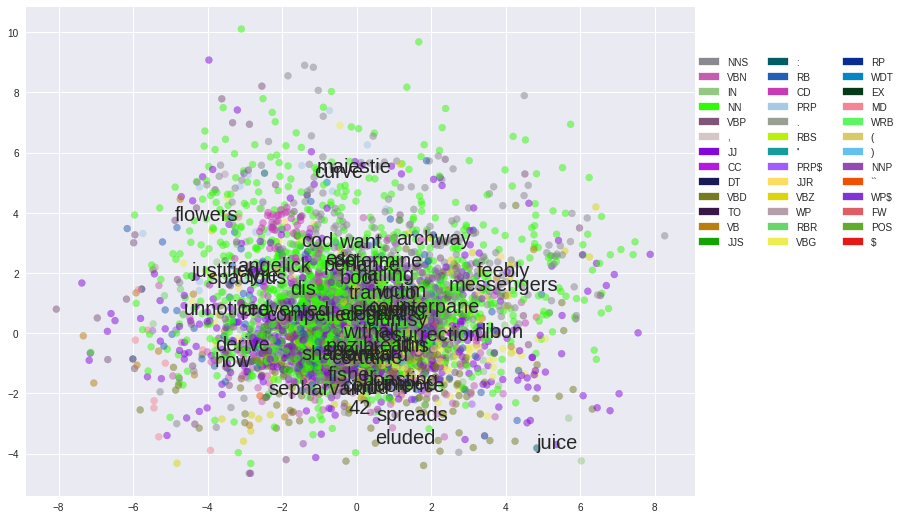

In [16]:
import matplotlib.patches as mpatches

# Color Mapping
colors = {}
for thing in df_tag['pos']:
  if thing not in colors.keys():
    colors[thing] = "#" + "".join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])

colormap = df_tag['pos'].map(colors)

# Creating a Larger Figure Size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9

# Scatter Plots
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], marker='o', alpha=0.5, c=colormap)

# Legends and Annotation
handles = [mpatches.Patch(color=colors[key], label=key) for key in colors]
plt.legend(handles=handles, ncol=3, loc=(1, 0.5))
for i, word in enumerate(np.random.choice(unique_words, 50)):
  plt.annotate(word, xy =(transformed_data[i, 0], transformed_data[i, 1]), fontsize=20)

plt.show()

Nltk also has a help function which describes what each part of speech is.

In [17]:
nltk.download('tagsets')
nltk.help.upenn_tagset()

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je j

Hmm, this scatter plot doesn't seem to show anything really useful. We can't seem to find any meaningful patterns in the data. However, this isn't all that unreasonable. With 100 dimensional data being reduced to two dimensions, we're certainly going to lose a lot explained variance. Let's plot the number of components against the explained variance to check:

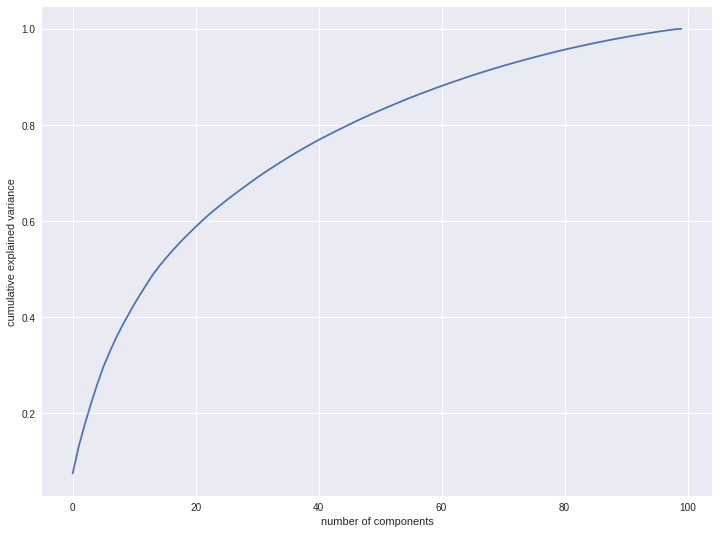

In [18]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Our plot seems to verify our suspicions - we simply can't see anything meaningful because two dimensions only explains 10-15% of our variance. 

### Sliding Window

**What is a sliding window?**

A sliding window is a number of "latest" words which are actually passed into our neural network. Suppose the value was `5`. Then, if we give our neural network a sentence like `"The color of my house is red. What color is your"`, we will pass into our neural network: `[".", "What", "color", "is", "your"]`, an array of length `5`. This is done so that we have a standard number of inputs which we give our neural network.

We'll pick a sliding window size of 10. Also, some methods are defined here to grab the word vectors and create masks, which make sure that all sentences are longer than our sliding window's value, and that all the vocabulary in the sentence is part our our Word2Vec vocabulary.

In [0]:
def get_word_vector(word):
  global w2v_model
  
  try:
    wv = w2v_model.wv[word]#.reshape(-1, 1)
    if len(wv) > 0:
      return wv
  except KeyError:
      return None
  return None

In [20]:
def mask_sliding_window(df, sliding_window):
  mask = df['tokenized_sentences'].str.len() > SLIDING_WINDOW
  df = df[mask]

  df['first_' + str(SLIDING_WINDOW) + '_words'] = df['tokenized_sentences'].map(lambda a: np.array([get_word_vector(i) for i in a[:SLIDING_WINDOW]]))
  df['next_word_after_' + str(SLIDING_WINDOW) + '_words'] = df['tokenized_sentences'].map(lambda a: a[SLIDING_WINDOW])

  mask1 = df['first_' + str(SLIDING_WINDOW) + '_words'].map(lambda a: a.shape == (SLIDING_WINDOW, 100))#(SLIDING_WINDOW, 100, 1))
  df = df[mask1]

  mask2 = df['next_word_after_' + str(SLIDING_WINDOW) + '_words'].map(lambda a: type(a) == str)
  df = df[mask2]
  return df

print('Original df shape:', df.shape)
SLIDING_WINDOW = 10
df = mask_sliding_window(df, SLIDING_WINDOW)
print('New df shape:', df.shape)
df.head()

Original df shape: (98552, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


New df shape: (65831, 4)


,tokenized_sentences,sentences,first_10_words,next_word_after_10_words
3,"[emma, woodhouse, ,, handsome, ,, clever, ,, a...","Emma Woodhouse, handsome, clever, and rich, wi...","[[-2.42913, -0.5385682, -1.9932795, 0.8718994,...",with
4,"[she, was, the, youngest, of, the, two, daught...",She was the youngest of the two daughters of a...,"[[-2.323719, -1.9243841, -1.4122108, -1.196021...",most
5,"[her, mother, had, died, too, long, ago, for, ...",Her mother had died too long ago for her to ha...,"[[-0.7961187, -2.1486797, -1.3584303, -2.62939...",have
6,"[sixteen, years, had, miss, taylor, been, in, ...",Sixteen years had Miss Taylor been in Mr. Wood...,"[[0.025084194, -0.14417212, -0.9108807, -0.498...",'
9,"[the, real, evils, ,, indeed, ,, of, emma, ', ...","The real evils, indeed, of Emma ' s situation ...","[[-0.13117175, -0.15085608, -0.4591953, -1.165...",situation


Now we have done a Word2Vec on all the `first_10_words`. We don't need to do a Word2Vec on the `next_word_after_10_words` because we will now be getting a class vector for the words. This is basically like "one-hot encoding" the words—we will get an array the size of our vocabulary, which will be filled almost entirely with 0s except for a 1 denoting our target word.

In [21]:
def get_class_vec(word):
    temp = np.zeros(len(unique_words), dtype = np.int8)
    try:
      temp[unique_words.index(word)] = 1
    except ValueError:
      pass
    return temp
   
df['class_vec'] = df['next_word_after_' + str(SLIDING_WINDOW) + '_words'].map(lambda a: get_class_vec(a))
df.head()

,tokenized_sentences,sentences,first_10_words,next_word_after_10_words,class_vec
3,"[emma, woodhouse, ,, handsome, ,, clever, ,, a...","Emma Woodhouse, handsome, clever, and rich, wi...","[[-2.42913, -0.5385682, -1.9932795, 0.8718994,...",with,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,"[she, was, the, youngest, of, the, two, daught...",She was the youngest of the two daughters of a...,"[[-2.323719, -1.9243841, -1.4122108, -1.196021...",most,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"[her, mother, had, died, too, long, ago, for, ...",Her mother had died too long ago for her to ha...,"[[-0.7961187, -2.1486797, -1.3584303, -2.62939...",have,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,"[sixteen, years, had, miss, taylor, been, in, ...",Sixteen years had Miss Taylor been in Mr. Wood...,"[[0.025084194, -0.14417212, -0.9108807, -0.498...",',"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,"[the, real, evils, ,, indeed, ,, of, emma, ', ...","The real evils, indeed, of Emma ' s situation ...","[[-0.13117175, -0.15085608, -0.4591953, -1.165...",situation,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Our pre-processing is looking great! Let's move on to the RNN.

## The RNN

Now, we're going to create our RNN, which will take in our input vector and predict the next word. This is a classification task, as we need to predict one word out of the individual word classes in our entire vocabulary.

### LSTM

**What is going on here?**

We're adding layers to our sequential model. Firstly, we'll use 3 LSTM layers to create a multidimensional recurrent neural network. LSTMs are useful for us because they allow us to go back a certain amount of words once we have a result and continue training. Since we  set a sliding window earlier, we can give our LSTM an input size with width equal to the sliding window. The LSTM will then train one word in the past, get a result, and then train the same result with two words into the past, etc... This is incredibly helpful to us because we want to be able to look a certain depth into the past to predict our next word.

Out of experimentation, we found that using many LSTM layers is better, so we've added three. A Dropout layer helps us with overfitting—it takes out a certain amount of random terms from our LSTM system in order to cross validate on them. The Dense layer and Activation allow us to actually get a probability for each word. We do want this because we want to predict more than one word sometimes (such as in iOS, where three words are shown above the keypad), and so knowing the probabilities of each word will help us sort the word predictions from most likely to least likely.

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation

def create_LSTM_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape=(None, 100)))
    model.add(LSTM(128, return_sequences = True, input_shape=(None, 100)))
    model.add(LSTM(128, input_shape=(None, 100)))
    model.add(Dropout(0.2))
    model.add(Dense(len(unique_words)))
    model.add(Activation('softmax'))
    return model
  
model = create_LSTM_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 15752)             2032008   
_________________________________________________________________
activation (Activation)      (None, 15752)             0         
Total params: 2,412,424
Trainable params: 2,412,424
Non-trainable params: 0
_________________________________________________________________


Now, we can split our dataset into train and test sets, and then format the data such that it's the right shape for our network.

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df)
train_features = 'first_' + str(SLIDING_WINDOW) + '_words'

train_target = 'next_word_after_' + str(SLIDING_WINDOW) + '_words'

In [24]:
X = train['first_' + str(SLIDING_WINDOW) + '_words'].values #get numpy arrays of values
y = train['class_vec'].values
X = np.array([i for i in X]) #makes sure shape is correct
y = np.array([i for i in y])
print(X.shape)
print(y.shape)

(49373, 10, 100)
(49373, 15752)


Now, we're ready to train. Much of the following code is just to help save and reload data, and was mostly used to speed up our development process.

In [0]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import files

checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # Save weights, every 5-epochs.
    period=5)

Here, we actually fit the model:

In [26]:
from tensorflow.train import RMSPropOptimizer

LEARNING_RATE = 0.01
EPOCHS = 12

optimizer = RMSPropOptimizer(LEARNING_RATE) # good choice for RNNs

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X,
                    y,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_split = 0.1,
                    verbose=1,
                    callbacks = [cp_callback], shuffle = True).history

Train on 44435 samples, validate on 4938 samples
Epoch 1/12
44435/44435 [==============================] - 45s 1ms/step - loss: 7.0900 - acc: 0.0986 - val_loss: 5.7942 - val_acc: 0.1270
Epoch 2/12
44435/44435 [==============================] - 40s 904us/step - loss: 5.5412 - acc: 0.1707 - val_loss: 5.4474 - val_acc: 0.1733
Epoch 3/12
44435/44435 [==============================] - 40s 893us/step - loss: 5.2672 - acc: 0.1879 - val_loss: 5.2840 - val_acc: 0.1936
Epoch 4/12
44435/44435 [==============================] - 39s 887us/step - loss: 5.1321 - acc: 0.1990 - val_loss: 5.2756 - val_acc: 0.1977
Epoch 5/12
44416/44435 [============================>.] - ETA: 0s - loss: 5.0411 - acc: 0.2060
Epoch 00005: saving model to training_2/cp-0005.ckpt
44435/44435 [==============================] - 39s 882us/step - loss: 5.0411 - acc: 0.2060 - val_loss: 5.2013 - val_acc: 0.1979
Epoch 6/12
44435/44435 [==============================] - 39s 872us/step - loss: 4.9915 - acc: 0.2110 - val_loss: 5.2447 

This part is just for saving and reloading a pre-trained version of our model, and isn't necessary to run.

In [27]:
print(os.listdir())
print(os.listdir('/content/training_2'))
latest = tf.train.latest_checkpoint('/content/training_2')
print(latest)

['.config', 'sample_data', 'training_2']
['cp-0005.ckpt.data-00000-of-00001', 'cp-0010.ckpt.index', 'cp-0005.ckpt.index', 'cp-0010.ckpt.data-00000-of-00001', 'checkpoint']
/content/training_2/cp-0010.ckpt


In [28]:
model.load_weights(latest)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
try:
   loss, acc = model.evaluate(X, y)
except:
   print('Pre-trained model not found')

print("Restored model, accuracy: {:5.2f}%".format(100*acc))

49373/49373 [==============================] - 54s 1ms/step
Restored model, accuracy: 23.39%


## Evaluation

Let's evaluate our model. The following methods help split up a normal sentence into tokens. The `predict` method is useful to define now because we will use it quite a bit to test.

In [0]:
import re

def sent_vec(tok_sent):
  output = []
  for word in tok_sent:
    if(type(get_word_vector(word.lower())) == np.ndarray):
       output.append([get_word_vector(word.lower())])
  return np.expand_dims(np.array(output).squeeze(), axis = 0)

def predict(model, sent, num_results=1):
  tok_sent = sent.replace('.', ' .')
  tok_sent = tok_sent.replace(',', ' ,')
  tok_sent = tok_sent.split(' ') #re.split('[,. ]', sent)
  assert len(tok_sent) >= SLIDING_WINDOW, "Please input a sentence of length " + str(SLIDING_WINDOW) + " or greater!"
  word_model = model.predict(sent_vec(tok_sent))
  first_N_words_idx = np.flip(word_model.argsort()[0], 0)[:num_results]
  first_N_words = []
  for word_idx in first_N_words_idx:
    first_N_words.append(unique_words[word_idx])
  if num_results > 1:
    return first_N_words
  return first_N_words[0]

In [30]:
word_model = predict(model, 'Call me Ishmael. Some years ago - never mind', 4)

word_model

[',', 'of', '.', 'in']

Not bad! Let's try and generate a script from the well-known opening lines of some novels.

In [0]:
def generate_paragraph(model, sent, words_to_add):
  result = sent
  for i in range(words_to_add):
    result = result + ' ' + predict(model, result)
  return result

In [43]:
generate_paragraph(model, "When he was nearly thirteen, my brother Jem got his arm badly broken at the", 10)

'When he was nearly thirteen, my brother Jem got his arm badly broken at the , and the and , and the and , and'

In [33]:
generate_paragraph(model, "It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness,", 10)

'It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, and the and , , and the and , ,'

Now, let's test our trained LSTM on our test set to see our test accuracy.

In [34]:
X_test = test['first_' + str(SLIDING_WINDOW) + '_words'].values
y_test = test['class_vec'].values

X_test = np.array([i for i in X_test])
y_test = np.array([i for i in y_test])

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy: {:5.2f}%".format(100*test_acc))

16458/16458 [==============================] - 18s 1ms/step
Test accuracy: 19.56%


**Why are so many words being repeated?**

After a while the model gets lost in its own wording. Since it only takes 10 words in the past, if all of the 10 words are the model's own words, then naturally, we can expect that the model will become less and less guided over time.

This is also a result of underfitting. In order to predict more successfully, we may, in the future, have a larger sliding window, or a flexible sliding window. We would definitely need a far larger dataset to make real-world predictions, like iOS does. But for our small(ish) datasets and small(ish) epochs, it looks like we've done fine. 

By plotting accuracy and loss against the progression of epochs in our model training history, we can estimate the optimal number of epochs.

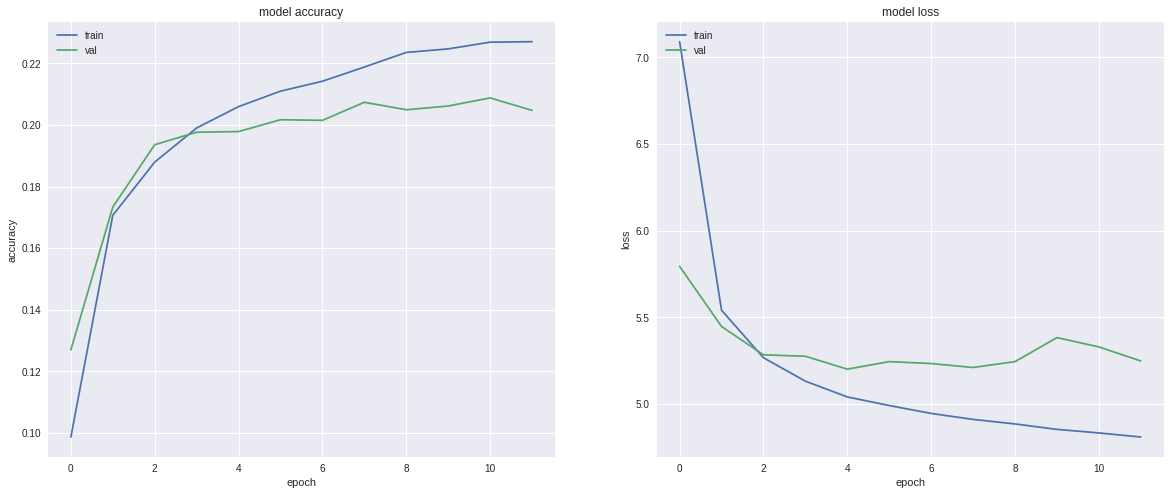

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(history['acc'])
ax[0].plot(history['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history['loss'])
ax[1].plot(history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()

On the whole, these diagrams are fair. We should expect that train accuracy and test accuracy go up (although naturally, train accuracy will be far better), and that train loss and test loss go down (and test loss will be higher). The problems stated above are reflected in the diagrams.



## Training Other Corpora


This is the basic structure of our program, all in one method. All of the hyper-parameters are parameters of this method.


In [0]:
def rnn_predict_words(sentences, blacklist=None, sliding_window=10, save_period=5, alpha=0.01, word_epochs=20, rnn_epochs=12, batch_size=128, validation_split=0.1, verbose=1):
  print('Loading dataframe...')
  df = pd.DataFrame(sentences, columns = ['tokenized_sentences'])

  def clean_sents(arr):
    result = [word.lower() for word in arr]
    if blacklist != None:
      for word in blacklist:
        result = list(filter(lambda x: x != word, result))
    return result

  print('Cleaning sentences...')
  df['tokenized_sentences'] = df['tokenized_sentences'].map(clean_sents)
  
  print('Creating a Word2Vec model...')
  w2v_model = create_w2v_model(df, word_epochs)
  unique_words = list(w2v_model.wv.vocab)
  df = mask_sliding_window(df, sliding_window)
  df['class_vec'] = df['next_word_after_' + str(sliding_window) + '_words'].map(lambda a: get_class_vec(a))

  print('Splitting train/test...')
  model = create_LSTM_model()
  train, test = train_test_split(df)
  train_features = 'first_' + str(sliding_window) + '_words'

  train_target = 'next_word_after_' + str(sliding_window) + '_words'
  X = train['first_' + str(sliding_window) + '_words'].values
  y = train['class_vec'].values
  X = np.array([i for i in X])
  y = np.array([i for i in y])

  print('Creating checkpoints...')
  checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  cp_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_path, verbose=1, save_weights_only=True,
      period=save_period)

  optimizer = RMSPropOptimizer(alpha)

  print('Training...')
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X,
                      y,
                      epochs=rnn_epochs,
                      batch_size=batch_size,
                      validation_split = validation_split,
                      verbose=verbose,
                      callbacks=[cp_callback],
                      shuffle=True).history
  return model

Now we can test our model trained on different text corpora. Here we've done the Brown corpus (compilation of text from 500 sources of varied genres), the Web Text corpus (more informal text from conversations, movie scripts, reviews, and advertisements), and the Inaugural Address corpus (collection of text from the 55 presidential addresses). More options of text corpora can be found here: https://www.nltk.org/book/ch02.html.

In [37]:
nltk.download('brown')
from nltk.corpus import brown
brown_sents = np.array(brown.sents()).reshape(-1, 1)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [38]:
nltk.download('webtext')
from nltk.corpus import webtext
webtext_sents = np.array(webtext.sents()).reshape(-1, 1)

[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


In [39]:
nltk.download('inaugural')
from nltk.corpus import inaugural
inaugural_sents = np.array(inaugural.sents()).reshape(-1, 1)

[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.


We start by cleaning our data for punctuation. We can try training the data with and without punctuation and compare the results to see if there is a significant change in quality.

In [40]:
brown_wo_punc = rnn_predict_words(brown_sents, blacklist=['.', ',', '\'', '\"', ';', ':', '[', ']', '--', '-', '!', '?'])
brown_w_punc = rnn_predict_words(brown_sents)
webtext_wo_punc = rnn_predict_words(webtext_sents, blacklist=['.', ',', '\'', '\"', ';', ':', '[', ']', '--', '-', '!', '?'])
webtext_w_punc = rnn_predict_words(webtext_sents)
inaugural_wo_punc = rnn_predict_words(inaugural_sents, blacklist=['.', ',', '\'', '\"', ';', ':', '[', ']', '--', '-', '!', '?'])
inaugural_w_punc = rnn_predict_words(inaugural_sents)

Loading dataframe...
Cleaning sentences...
Creating a Word2Vec model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Splitting train/test...
Creating checkpoints...
Training...
Train on 7186 samples, validate on 799 samples
Epoch 1/12
7186/7186 [==============================] - 10s 1ms/step - loss: 8.5672 - acc: 0.0552 - val_loss: 8.5531 - val_acc: 0.0626
Epoch 2/12
7186/7186 [==============================] - 7s 910us/step - loss: 7.6706 - acc: 0.0675 - val_loss: 6.6867 - val_acc: 0.0038
Epoch 3/12
7186/7186 [==============================] - 7s 915us/step - loss: 6.1505 - acc: 0.0614 - val_loss: 6.2603 - val_acc: 0.0626
Epoch 4/12
7186/7186 [==============================] - 7s 921us/step - loss: 5.8464 - acc: 0.0732 - val_loss: 6.3516 - val_acc: 0.0638
Epoch 5/12
7168/7186 [============================>.] - ETA: 0s - loss: 5.4672 - acc: 0.0949
Epoch 00005: saving model to training_2/cp-0005.ckpt
7186/7186 [==============================] - 7s 979us/step - loss: 5.4666 - acc: 0.0952 - val_loss: 6.0792 - val_acc: 0.0864
Epoch 6/12
7186/7186 [==============================] - 7s 910us/step - loss: 5

After training, we can take a look at the accuracy and loss history plots.

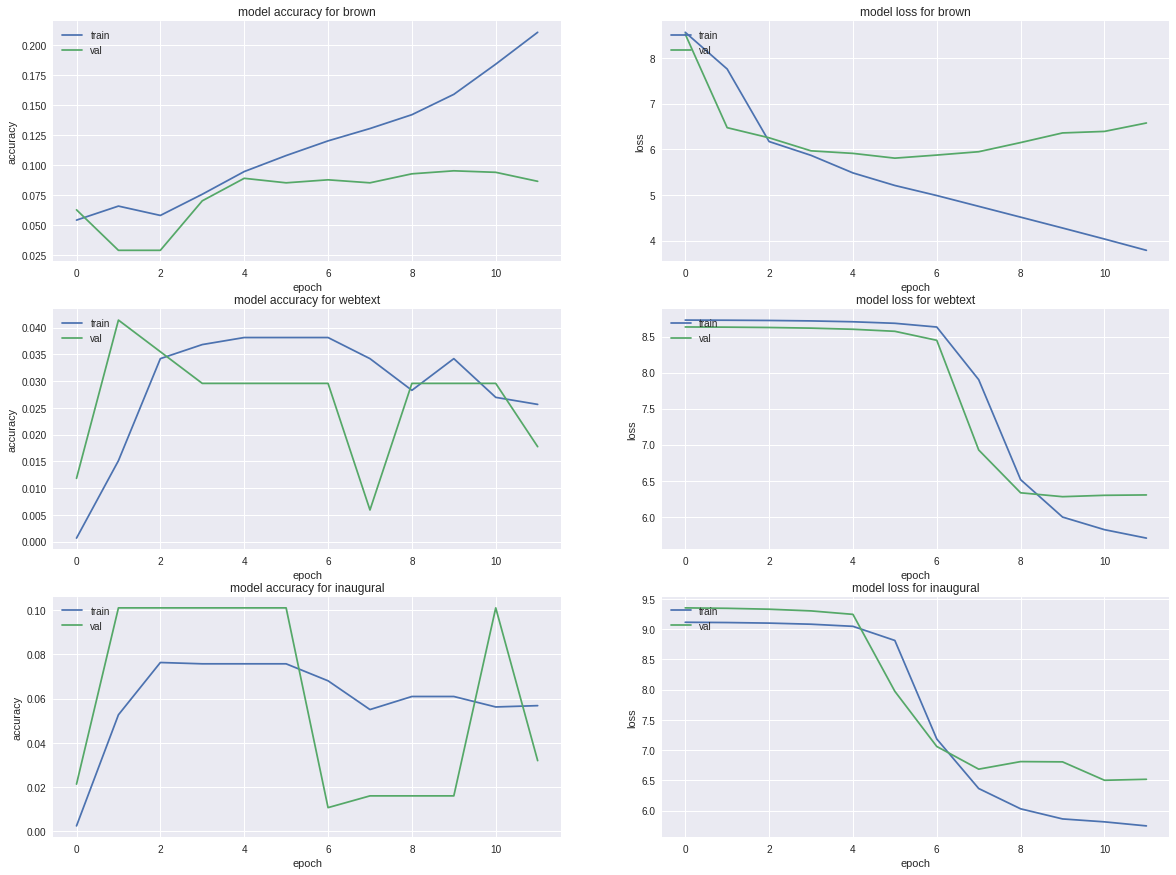

In [41]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
ax[0][0].plot(brown_w_punc.history.history['acc'])
ax[0][0].plot(brown_w_punc.history.history['val_acc'])
ax[0][0].set_title('model accuracy for brown')
ax[0][0].set_ylabel('accuracy')
ax[0][0].set_xlabel('epoch')
ax[0][0].legend(['train', 'val'], loc='upper left')

ax[0][1].plot(brown_w_punc.history.history['loss'])
ax[0][1].plot(brown_w_punc.history.history['val_loss'])
ax[0][1].set_title('model loss for brown')
ax[0][1].set_ylabel('loss')
ax[0][1].set_xlabel('epoch')
ax[0][1].legend(['train', 'val'], loc='upper left')

ax[1][0].plot(webtext_w_punc.history.history['acc'])
ax[1][0].plot(webtext_w_punc.history.history['val_acc'])
ax[1][0].set_title('model accuracy for webtext')
ax[1][0].set_ylabel('accuracy')
ax[1][0].set_xlabel('epoch')
ax[1][0].legend(['train', 'val'], loc='upper left')

ax[1][1].plot(webtext_w_punc.history.history['loss'])
ax[1][1].plot(webtext_w_punc.history.history['val_loss'])
ax[1][1].set_title('model loss for webtext')
ax[1][1].set_ylabel('loss')
ax[1][1].set_xlabel('epoch')
ax[1][1].legend(['train', 'val'], loc='upper left')

ax[2][0].plot(inaugural_w_punc.history.history['acc'])
ax[2][0].plot(inaugural_w_punc.history.history['val_acc'])
ax[2][0].set_title('model accuracy for inaugural')
ax[2][0].set_ylabel('accuracy')
ax[2][0].set_xlabel('epoch')
ax[2][0].legend(['train', 'val'], loc='upper left')

ax[2][1].plot(inaugural_w_punc.history.history['loss'])
ax[2][1].plot(inaugural_w_punc.history.history['val_loss'])
ax[2][1].set_title('model loss for inaugural')
ax[2][1].set_ylabel('loss')
ax[2][1].set_xlabel('epoch')
ax[2][1].legend(['train', 'val'], loc='upper left')

plt.show()

It seems like the model found the most success with the Inaugural Address corpus, although the model's improvement seems to slow after 6-8 epochs for all of the corpora.

In [42]:
print('Brown without punc:', generate_paragraph(brown_wo_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))
print('Brown with punc:', generate_paragraph(brown_w_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))
print('Webtext without punc:', generate_paragraph(webtext_wo_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))
print('Webtext with punc:', generate_paragraph(webtext_w_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))
print('Inaugural without punc:', generate_paragraph(inaugural_wo_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))
print('Inaugural with punc:', generate_paragraph(inaugural_w_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))

Brown without punc: When he was nearly thirteen, my brother Jem got his arm badly broken in a way and he had been had been had
Brown with punc: When he was nearly thirteen, my brother Jem got his arm badly broken well but it could been a place is out of
Webtext without punc: When he was nearly thirteen, my brother Jem got his arm badly broken to to to to to to to to to to
Webtext with punc: When he was nearly thirteen, my brother Jem got his arm badly broken it it it it it it it it it it
Inaugural without punc: When he was nearly thirteen, my brother Jem got his arm badly broken our our our our our our our our our our
Inaugural with punc: When he was nearly thirteen, my brother Jem got his arm badly broken in in in in in in in in in in


These vary a lot in quality, and this could be because of a combination of factors including the differing number of words and sentences in the datasets or just the different styles of writing across the text corpora. Overall, removing the punctuation did not seem to have that much of an impact on the output.


##Annotated Bibliography:

###1) What are RNNs and LSTMs:

Recurrent Neural Networks (An Introduction to Concept) (https://www.youtube.com/watch?v=6niqTuYFZLQ)
This video offers a basic introduction to recurrent neural networks (RNNs). Although it’s rather long, the content from 9:00 - 22:00 is pretty useful.

Understanding LSTM Networks (https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
This article explains what RNNs and LSTMs are and how they work. 

Why are deep neural networks hard to train? (http://neuralnetworksanddeeplearning.com/chap5.html)
This article explains the exploding and unstable gradient problems that come with a deep recurrent neural network.

###2) Finding Text Datasets:

Accessing Text Corpora and Lexical Resources (https://www.nltk.org/book/ch02.html)
This page describes the different text corpora, or text collections, available in the NLTK library. We trained our model using the Brown corpus, which compiles text from 500 sources including news, mystery, and fiction texts, and the Gutenburg Corpus, which contains a small collection of electronic book texts.

###3) Processing Text and Converting Words to Vectors:

Tokenization and Parts of Speech(POS) Tagging in Python’s NLTK library (https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b)
This page describes NLTK’s part of speech tagger and provides a list of the different parts of speech. We used this in our visualization of Word2Vec to color our plot by parts of speech. 

Word embeddings: how to transform text into numbers (https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/)
This page compares uses of word vectors versus one-hot encoders, suggests how to evaluate their reasonableness, and explains how word vectors are created.

models.word2vec – Word2vec embeddings (https://radimrehurek.com/gensim/models/word2vec.html)
This page briefly mentions different methods of word embeddings and gives examples of how to use Word2Vec.

Vector Representations of Words (https://www.tensorflow.org/tutorials/representation/word2vec)
This tutorial describes the uses of word embedding, how the Word2Vec model works, and how to implement a model. 

How to get started with Word2Vec — and then how to make it work (https://medium.freecodecamp.org/how-to-get-started-with-word2vec-and-then-how-to-make-it-work-d0a2fca9dad3)
This article explains what Word2Vec is and how to use the Gensim implementation. 

Predicting a word using Word2vec model (https://datascience.stackexchange.com/questions/9785/predicting-a-word-using-word2vec-model)
This page suggests ways to fill in a missing word based on context words including using the Word2Vec function predict_output_word().

###4) Implementing the Model: 

Recurrent Neural Networks (An Introduction to Implementation) (https://www.tensorflow.org/tutorials/sequences/recurrent)
This tutorial illustrates how to implement a recurrent neural network using tensorflow.

Making a Predictive Keyboard using Recurrent Neural Networks (with LSTMs in tensorflow) 
(https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218)
This blog post gives a general introduction to the advantages of using a recurrent neural network and demonstrates how to make one using LSTM units (Long short-term memory) to avoid the vanishing gradient problem. Given input data, the completed program continues to predict characters until it predicts a space. 

Text generation using a RNN with eager execution (https://www.tensorflow.org/tutorials/sequences/text_generation)
This guide illustrates how to implement and train a text prediction model using Shakespeare text. The final model predicts text character by character.

Understanding LSTM and its Quick Implementation in Keras for Sentiment Analysis (https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47)
This is another explanation of RNNs and LSTMs which includes an example of how to use them for Sentiment Analysis on Yelp reviews. 

How to Develop a Character-Based Neural Language Model in Keras (https://machinelearningmastery.com/develop-character-based-neural-language-model-keras/)
This is a general tutorial to create a model that predicts a user-defined number of characters given an input of ten characters.

Implementing a Multi-Layer RNN for a Character-Level Language Model in Torch
(https://github.com/karpathy/char-rnn)
This guide demonstrates how to use Torch to create and train a RNN that outputs text character by character.

###5) Formatting Model for Input Data of Variable Length: 

Training an RNN with examples of different lengths in Keras (https://datascience.stackexchange.com/questions/26366/training-an-rnn-with-examples-of-different-lengths-in-keras)
This page suggests ways to adjust your model to make predictions on inputs of variable character and word length.

Variable Sequence Lengths in TensorFlow (https://danijar.com/variable-sequence-lengths-in-tensorflow/)
This blog explains how to implement RNNs for variable-length inputs padded with 0s

###6) Training and Testing: 

How to Diagnose Overfitting and Underfitting of LSTM Models (https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/)
This post shows you how to plot the training history of your model and determine whether it is overfit/underfit or properly fitted. It also explains why you might want to plot multiple runs. 

LSTM Overfitting (https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/46494)
This page offers some suggestions to deal with overfitting a model on a small dataset.

RNN Training Tips and Tricks (https://towardsdatascience.com/rnn-training-tips-and-tricks-2bf687e67527)
This page suggests ways to refine your model and deal with overfitting and underfitting.

Save and restore models (https://www.tensorflow.org/tutorials/keras/save_and_restore_models)
This tutorial explains different methods of saving trained Tensorflow models. 
